In [1]:
import sys
sys.path.append("/home/roozbeh/Neuron Morphology")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import McNeuron
import zoom_in
import scipy
import itertools
from itertools import product
%matplotlib inline

## Import skeleton data

In [2]:
path = './20180319_published_neurons_Drosophila_larval_first-instar_CNS/'
skeleton_coordinates = pd.read_csv(path + 'skeleton_coordinates.csv')
# connectors = pd.read_csv(path + 'connectors.csv')
# neuron_names = pd.read_csv(path + 'neuron_names.csv', error_bad_lines=False);
# synapses = pd.read_csv(path + 'skeleton_coordinates.csv')

## Analysis

In [9]:
box_skeleton = \
    zoom_in.util.get_nodes_in_box(skeleton_coordinates, 
                                  centroid = [60000, 80000, 100000], 
                                  radius = 5000)

box_skeleton = zoom_in.util.connected_components_in_skeletons(box_skeleton)
list_swc = zoom_in.util.get_all_neurites_in_box(box_skeleton)

In [10]:
S = McNeuron.subsample.Subsample()
reg_swc = zoom_in.util.get_regularized(S, list_swc)
parent_list = zoom_in.util.get_parent_index(reg_swc)
branch_list = zoom_in.util.branch_decompose(parent_list, down_depth=3)
motifs = [np.array([0,0,0]), np.array([0,0,0, 1, 1]), np.array([0,0,0, 1, 1, 2, 2])]
counts = zoom_in.util.count_motifs(motifs, trees=branch_list)

## Plotting Results

In [ ]:
# The whole dataset
centroids = [60000, 80000, 100000]
r = 5000
x = skeleton_coordinates[' x']
y = skeleton_coordinates[' y']
z = skeleton_coordinates[' z']
xyz = np.zeros([len(x), 3])
xyz[:, 0] = x
xyz[:, 1] = y
xyz[:, 2] = z
n_point = np.where(np.linalg.norm(xyz - centroids, 
                                  ord=1, axis=1)< r)[0]
plt.scatter(x[n_point], y[n_point], s = 1)
plt.axis([centroids[0]-r, centroids[0]+r,centroids[1]-r, centroids[1]+r])
plt.axis('off')
#plt.savefig('brain_xy_box.eps')
#plt.show()
plt.scatter(x[n_point], z[n_point], s = 1)
plt.axis('equal')
plt.axis('off')
#plt.savefig('brain_xz_box.eps')
# plt.show()
plt.scatter(y[n_point], z[n_point], s = 1)
plt.axis('equal')
plt.axis('off')
#plt.savefig('brain_yz_box.eps')
# plt.show()

In [ ]:
up = 4000000
plt.scatter(skeleton_coordinates[' x'][:up], skeleton_coordinates[' y'][:up], s = .01)
#plt.savefig('brain_xy')
#plt.show()
plt.scatter(skeleton_coordinates[' x'][:up], skeleton_coordinates[' z'][:up], s = .01)
#plt.savefig('brain_xz')
# plt.show()
plt.scatter(skeleton_coordinates[' y'][:up], skeleton_coordinates[' z'][:up], s = .01)
#plt.savefig('brain_yz')
# plt.show()


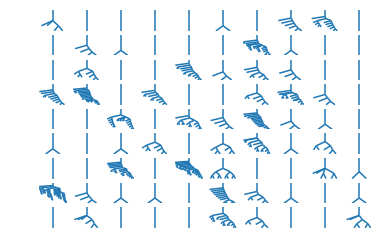

In [11]:
f, ax = plt.subplots(9, 10)
for i in range(90):#range(len(reg_neurites)):
    x = np.mod(i, 9)
    y = int(i/9.)
    McNeuron.visualize.plot_dendrogram(McNeuron.Neuron(reg_swc[i]), pass_ax=True, ax=ax[x,y])
    #McNeuron.visualize.plot_dendrogram(McNeuron.Neuron(reg_swc[i]))
#plt.savefig('all_dendrogram_neurites.eps')

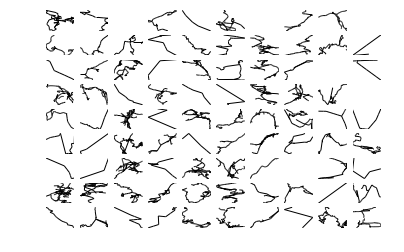

In [12]:
f, ax = plt.subplots(9, 10)

for i in range(90):#range(len(reg_neurites)):
    x = np.mod(i, 9)
    y = int(i/9.)
    McNeuron.visualize.plot_2D(McNeuron.Neuron(list_swc[i]), pass_ax=True, ax=ax[x,y])
    #McNeuron.visualize.plot_dendrogram(McNeuron.Neuron(reg_swc[i]))
#plt.savefig('all_neurites.eps')

## Codes Under Construction

In [ ]:
from zoom_in.util import refresh_id
from zoom_in.util import get_depth
from zoom_in.util import inverse_array
from zoom_in.util import get_swc
from copy import deepcopy

def push_max_index_for_roots(index_id, parent_id):
    index_id, parent_id = refresh_id(index_id, parent_id)

    big_number = parent_id.max() +  index_id.max()
    border_id = np.array(list(set(parent_id) - set(index_id)))
    border_index = np.array([])
    for i in border_id:
        border_index = np.append(border_index, np.where(parent_id == i)[0])
    parent_id[border_index.astype(int)] = 2*big_number + np.arange(len(border_index))

    index_id, parent_id = refresh_id(index_id, parent_id)
    
    return index_id, parent_id

def get_inverse_based_on_depth(depth):
    n_node = len(depth)
    permutation = np.zeros(n_node)
    start = 0
    for i in range(depth.max()+1):
        level_set = depth==i
        node_in = sum(level_set)
        permutation[level_set] = range(start, start+ node_in)
        start += node_in
    permutation = permutation.astype(int)
    permutation = inverse_array(permutation)
    return permutation.astype(int)

def box_skeleton_with_depth(box_skeleton):
    """Returning the swc of one neurite (with cc==index) from the skeleton.
    Parameters:
    -----------
    box_skeleton: pandas
        Dataframe of all nodes. It should have these keys: ['skeleton_id', 
        'cc_skeleton_id', ' treenode_id', ' parent_treenode_id', ' x', ' y', ' z', ' r']

    index: int
        Index of connected component
    
    Returns:
    --------
    swc: numpy
    
    part_neuron: panadas
        A Dataframe with the structure of box_skeleton for the extracted neurites.
        It has two extra keys: ' new_treenode_id' and ' new_parent_treenode_id'
    
    """
    box_skeleton_with_depth = deepcopy(box_skeleton)
    index_id = np.array(box_skeleton_with_depth[' treenode_id']).astype(int)
    parent_id = np.array(box_skeleton_with_depth[' parent_treenode_id']).astype(int)

    index_id, parent_id = push_max_index_for_roots(index_id, parent_id)
    # getting the depth
    depth = get_depth_for_many_neurites(index_id, parent_id)
    box_skeleton_with_depth[' depth'] = depth
    box_skeleton_with_depth[' new_parent_treenode_id'] = parent_id
    box_skeleton_with_depth[' new_treenode_id']  = index_id
    permutation = get_inverse_based_on_depth(depth)
    box_skeleton_with_depth = box_skeleton_with_depth.iloc[permutation]
    
    return box_skeleton_with_depth


def get_depth_for_many_neurites(index_id, parent_id):
    """Returning the (centrifugal) depth of each node. Notice that index should be between 0 and number of
    nodes and the id of parent of somas should start from n_node (to #soma+ n_node).
    
    Parameters:
    -----------
    index_id: numpy
        id of nodes.
    parent_id: numpy
        parent_id of nodes

    Returns:
    --------
    depth: numpy
        (centrifugal) depth of each node. 
    """
    
    end_index_id = index_id.max()
    n_neurites = parent_id.max() - index_id.max()
    extra_nodes = np.arange(end_index_id+1, end_index_id+1 + n_neurites)

    ext_parent_id = np.append(parent_id, extra_nodes)
    ext_inv_index_id = np.append(inverse_array(index_id),extra_nodes).astype(int)
    
    depth = np.zeros(ext_inv_index_id.shape[0])
    grand_parent_id = ext_parent_id
    far_index = grand_parent_id < end_index_id
    
#    i = 0
    while sum(far_index)!=0:
        depth[far_index] = depth[far_index] + 1
        grand_parent_id = ext_parent_id[ext_inv_index_id[grand_parent_id]] 
        far_index = grand_parent_id < end_index_id
    depth = depth[:end_index_id+1]
    depth = depth.astype(int) 
    return depth



In [ ]:
#list_swc = get_all_neurites_in_box(box_skeleton)
#get_depth_for_many_neurites(index_id, parent_id)
bx = box_skeleton_with_depth(box_skeleton)
parent_id = bx[' new_parent_treenode_id']
index_id = bx[' new_treenode_id']

I = np.where(n['cc_skeleton_id']==99)[0]
n2 = n.iloc[I]
n2

swc, part_neuron = get_one_neurite_in_box(box_skeleton, index=5)
index_id = np.array(part_neuron[' new_treenode_id']).astype(int)
parent_id = np.array(part_neuron[' new_parent_treenode_id']).astype(int)
print index_id, parent_id
print get_depth_for_many_neurites(index_id, parent_id) 
print np.array(part_neuron[' depth']).astype(int)